In [1]:
import keras
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_upsampled = np.zeros(shape=(X_train.shape[0], 56, 56, 1))
batch_size = 30
i = 0
for img in X_train:
    a = scipy.ndimage.zoom(img, (2,2,1), order=0)
    X_train_upsampled[i] = a
    i += 1
    

print(X_train.shape[0])
print('Resampled by a factor of 2 with nearest interpolation:')
#print(scipy.ndimage.zoom(X_train, 2, order=0)) 


60000
Resampled by a factor of 2 with nearest interpolation:


In [3]:
i = 0
X_train_upsampled_2 = np.zeros(shape=(X_train.shape[0], 56, 56, 3))
for img in X_train_upsampled:
    a = np.repeat(img,3, axis=-1)
    X_train_upsampled_2[i] = a
    i += 1

In [4]:
epochs=100

train_datagen = ImageDataGenerator(rotation_range=8, 
                                   width_shift_range=0.08,
                                   shear_range=0.3,
                                   height_shift_range=0.08,
                                   zoom_range=0.08)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_upsampled_2, 
                                     y_train, 
                                     batch_size=30)

test_generator = test_datagen.flow(X_test,
                                   y_test, 
                                   batch_size=30)


data batch shape: (30, 56, 56, 3)
labels batch shape: (30,)


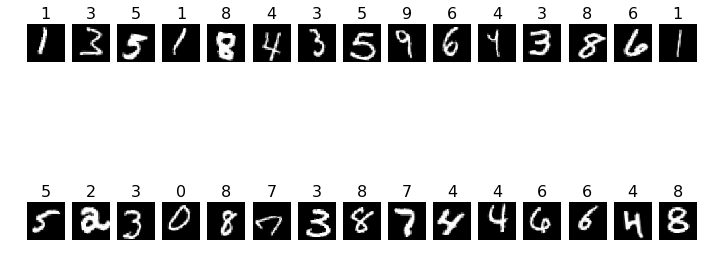

In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
data_batch, labels_batch = next(train_generator)

def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3 :
            ims = ims.transpose(0,2,3,1)
    
    f = plt.figure(figsize=figsize)
    
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none', cmap='gray')
        
plots(data_batch, titles = labels_batch)

# Load VGG Model

In [6]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(56, 56, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0         
__________

In [7]:
def extract_features(sample_count, generator):
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    labels = np.zeros(shape=(sample_count))
    
    i = 0   
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [8]:
 train_features, train_labels = extract_features(60000, train_generator)

In [9]:
from sklearn.cluster import KMeans
train_features = np.squeeze(train_features)
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(train_features)
kmeans.cluster_centers_.shape
#train_features.shape
#KK = np.squeeze(train_features)
#KK.shape

(10, 512)

ValueError: cannot reshape array of size 5120 into shape (10,8,8)

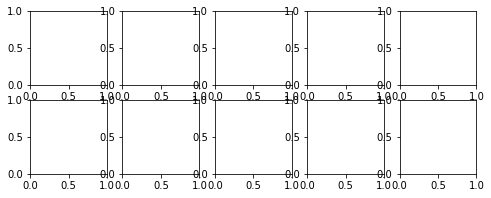

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [ ]:
plt.scatter(train_features[:, 0], train_features[:, 1], c=y_kmeans, s = 50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s = 200, alpha=0.5);

In [11]:
import scipy.io
scipy.io.savemat('features_for_clustering.mat', dict(x=train_features.tolist(), y=train_labels.tolist()))